In [1]:
import numpy as np
from numpy import sin, pi, exp
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw

# General Domain size

In [2]:
# horizontal grid cells
nx = 60
ny = 40

# choose vertical resolution
dr=np.array(40*np.ones(100))
nr = len(dr)
rF = (np.insert(np.cumsum(dr),0,0)) # z-coordinates of vertical cell faces
z = np.diff(rF)/2 + rF[:-1]         # z-coordinates of vertical cell centers
H = -np.sum(dr)  
print(H)
# horizontal resoluiton in km 25
dx=25
dy=25
X=np.arange(0,nx*dx,dx)
Y=np.arange(0,ny*dx,dy)

-4000.0


# Velocity boundary condition

# Initial T-field and T-field to restore to 20 layer case

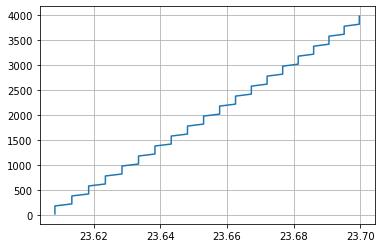

In [27]:
#create vertical T-profile
Tprof=np.linspace(5,4.05,20)    
Tprof100=np.zeros(100)+5
for zz in range(1,20):
    zini=zz*5
    Tprof100[zini:zini+5]=Tprof[zz]
Tprof100

sigma0=gsw.sigma0((np.zeros((Tprof100).shape))+30,Tprof100)
plt.plot(sigma0,z)
plt.grid()

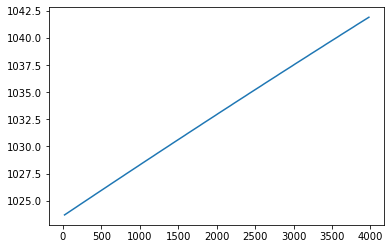

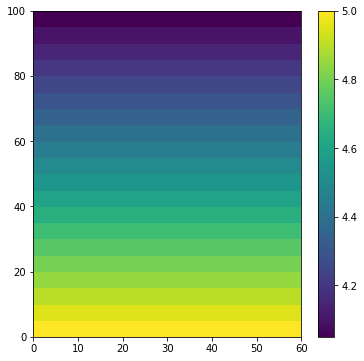

In [20]:
# make the profile to a 3D field
Tini_field = np.zeros((nx,ny,nr))+Tprof100
Tini=Tini_field.T

plt.figure(figsize=(6,6))
cb=plt.pcolormesh(Tini[:,20,:])
plt.colorbar(cb)

In [21]:
# create boundary files for obcs with dimension t(=x),z,y
print(Tini.shape)
Tini.astype('>f4').tofile(f'T_ini20l_{len(dr)}_25km.bin')
Tobcs=np.transpose(Tini,(2,0,1))
Tobcs.shape

#Tobcs.astype('>f4').tofile(f'T_obcs20l_{len(dr)}_25km.bin')

(100, 40, 60)


(60, 100, 40)

In [22]:
# add to the linear stratification a meridional gradient, but keep the meridional average as in the 20 equal layers
T_20l_dTdy=np.zeros((100,40))
print(T_20l_dTdy.shape)
for zz in range(0,100):
        T_20l_dTdy[zz,:]=Tprof100[zz]+(0.2*Tprof100[zz]/ny)*(-19.5+Y/dy)
        
T_20l_dTdy_ini=np.repeat(T_20l_dTdy[ :, :,np.newaxis], nx, axis=2)
print(T_20l_dTdy_ini.shape)
T_dTdy_3d=np.repeat(T_20l_dTdy[np.newaxis, :, :], nx, axis=0)
T_dTdy_3d.shape

(100, 40)
(100, 40, 60)


(60, 100, 40)

In [23]:
T_20l_dTdy_ini.astype('>f4').tofile(f'T_ini20l_wdTdy_{len(dr)}_25km.bin')
T_dTdy_3d.astype('>f4').tofile(f'T_obcs20l_wdTdy_{len(dr)}_25km.bin')

(60, 100, 40)
(60, 100, 40)


Text(0.5, 1.0, 'meridional average')

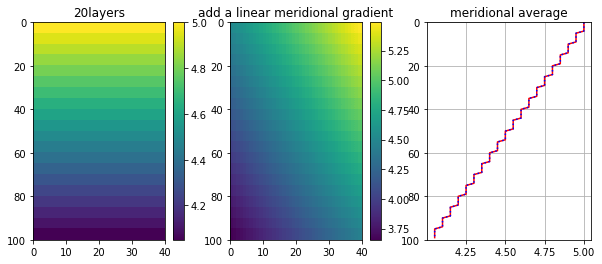

In [24]:
print(Tobcs.shape)
print(T_dTdy_3d.shape)

fig,axes=plt.subplots(1,3,figsize=(10,4),gridspec_kw={'width_ratios':[1,1,1]})
cb=axes[0].pcolormesh(Tobcs[59,:,:])
axes[0].invert_yaxis()
plt.colorbar(cb,ax=axes[0]) 
axes[0].set_title('20layers')

cb=axes[1].pcolormesh(T_dTdy_3d[59,:,:])
axes[1].invert_yaxis()
axes[1].set_title('add a linear meridional gradient')
plt.colorbar(cb,ax=axes[1]) 

axes[2].plot(Tobcs.mean(axis=2)[59,:],np.arange(0,100,1),color='r',label='20layers')
axes[2].plot(T_dTdy_3d.mean(axis=2)[59,:],np.arange(0,100,1),color='b',ls=':',label='add a gradient')
axes[2].set_ylim(0,100)
axes[2].invert_yaxis()
axes[2].grid()
axes[2].set_title('meridional average')

In [25]:
print(T_dTdy_3d.shape)
np.transpose(T_dTdy_3d,(1,2,0)).shape

(60, 100, 40)


(100, 40, 60)

(60, 40, 100)
(60, 100, 40)


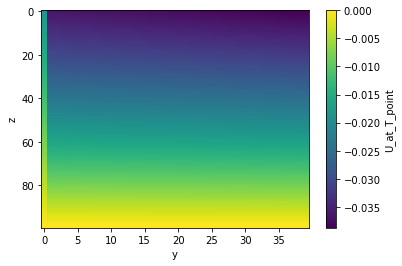

In [26]:
# compute density from T_field
g=9.81
f=gsw.f(-65)
# compute pressure and density
p=np.zeros((nx,ny,nr))+gsw.p_from_z(-1*z,-65)
print(p.shape)
rho=gsw.rho(np.zeros(np.transpose(T_dTdy_3d,(1,2,0)).shape)+30,np.transpose(T_dTdy_3d,(1,2,0)), p.T)
rho.shape
ds = xr.Dataset()
ds['rho'] = (('z', 'y', 'x'), rho)
ds = ds.assign_coords(x=ds.x, y=ds.y, z=ds.z)
ds.x.attrs['axis'] = 'X'
ds.y.attrs['axis'] = 'Y'
ds.z.attrs['axis'] = 'Z'
ds = xgcm.generate_grid_ds(ds, {'X':'x', 'Y':'y', 'Z':'z'})
grid = xgcm.Grid(ds, periodic=False)
ds['dr'] = ('z', dr)
rev = -1*(g/f)*grid.cumsum(
    (
        grid.interp(1/ds.rho, 'Y', boundary='extend') * grid.diff(ds.rho, 'Y', boundary='extend') / (dy*10**3)
    ) * ds.dr,
    'Z',
    boundary='fill',
    fill_value=0
)
velocity = rev.isel(z_left=-1) - rev
ds['U_at_T_point'] = grid.interp(velocity, ['Y', 'Z'], boundary='extend')
ds['U_at_T_point'].mean('x').plot(y='z', yincrease=False)
U_tw=np.asarray(ds.U_at_T_point.transpose("x", "z", "y"))
print(U_tw.shape)
U_tw.astype('>f4').tofile(f'Uvel_tw_20lwdTdy_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 

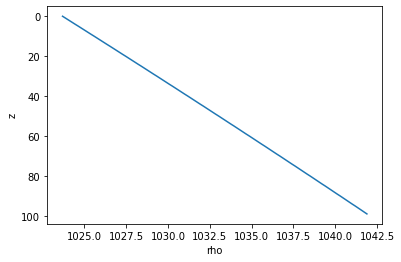

In [27]:
ds.rho.mean(dim={'x','y'}).plot(y="z")
plt.gca().invert_yaxis()

In [28]:
ds.U_at_T_point.isel(x=59).mean(dim={'y','z'})

<xarray.DataArray 'U_at_T_point' ()>
array(-0.0196341)
Coordinates:
    x        int64 59

-0.09963409551264907
(60, 100, 40)


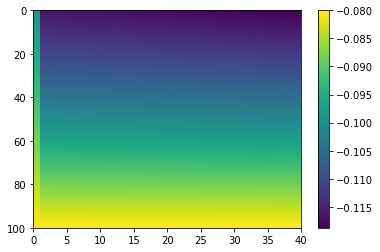

In [30]:
# add to the thermal wind a barotropic component
U_utw=U_tw-0.08
print(U_utw[59,:,:].mean(axis=1).mean(axis=0))
plt.pcolormesh(U_utw[59,:,:])
plt.colorbar()
plt.gca().invert_yaxis()
print(U_utw.shape)
U_utw.astype('>f4').tofile(f'Uvel_utw_20lwdTdy_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 

-0.11963409551264906
(60, 100, 40)


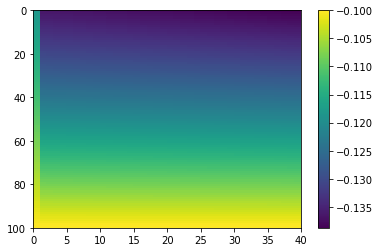

In [31]:
# add to the thermal wind a barotropic component
U_utw=U_tw-0.1
print(U_utw[59,:,:].mean(axis=1).mean(axis=0))
plt.pcolormesh(U_utw[59,:,:])
plt.colorbar()
plt.gca().invert_yaxis()
print(U_utw.shape)
U_utw.astype('>f4').tofile(f'Uvel_u01tw_20lwdTdy_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 

(100, 40)
(100, 40, 60)
(60, 40, 100)
<xarray.DataArray 'U_at_T_point' ()>
array(-0.0981868)
Coordinates:
    x        int64 59
(60, 100, 40)


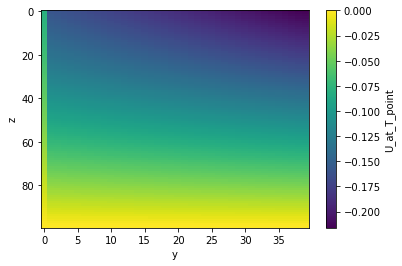

In [19]:
# increase the meridional gradient so that the thermal wind verlocities are approx -0.1 m/s
# add to the linear stratification a meridional gradient, but keep the meridional average as in the 20 equal layers
T_20l_dTdy=np.zeros((100,40))
print(T_20l_dTdy.shape)
for zz in range(0,100):
        T_20l_dTdy[zz,:]=Tprof100[zz]+(Tprof100[zz]/ny)*(-19.5+Y/dy)
        
T_20l_dTdy_ini=np.repeat(T_20l_dTdy[ :, :,np.newaxis], nx, axis=2)
print(T_20l_dTdy_ini.shape)
T_dTdy_3d=np.repeat(T_20l_dTdy[np.newaxis, :, :], nx, axis=0)
T_dTdy_3d.shape
T_20l_dTdy_ini.astype('>f4').tofile(f'T_ini20l_wdTdy_tw01_{len(dr)}_25km.bin')
T_dTdy_3d.astype('>f4').tofile(f'T_obcs20l_wdTdy_tw01_{len(dr)}_25km.bin')
# compute density from T_field
g=9.81
f=gsw.f(-65)
# compute pressure and density
p=np.zeros((nx,ny,nr))+gsw.p_from_z(-1*z,-65)
print(p.shape)
rho=gsw.rho(np.zeros(np.transpose(T_dTdy_3d,(1,2,0)).shape)+30,np.transpose(T_dTdy_3d,(1,2,0)), p.T)
rho.shape
ds = xr.Dataset()
ds['rho'] = (('z', 'y', 'x'), rho)
ds = ds.assign_coords(x=ds.x, y=ds.y, z=ds.z)
ds.x.attrs['axis'] = 'X'
ds.y.attrs['axis'] = 'Y'
ds.z.attrs['axis'] = 'Z'
ds = xgcm.generate_grid_ds(ds, {'X':'x', 'Y':'y', 'Z':'z'})
grid = xgcm.Grid(ds, periodic=False)
ds['dr'] = ('z', dr)
rev = -1*(g/f)*grid.cumsum(
    (
        grid.interp(1/ds.rho, 'Y', boundary='extend') * grid.diff(ds.rho, 'Y', boundary='extend') / (dy*10**3)
    ) * ds.dr,
    'Z',
    boundary='fill',
    fill_value=0
)
velocity = rev.isel(z_left=-1) - rev
ds['U_at_T_point'] = grid.interp(velocity, ['Y', 'Z'], boundary='extend')
ds['U_at_T_point'].mean('x').plot(y='z', yincrease=False)
print(ds.U_at_T_point.isel(x=59).mean(dim={'y','z'}))
U_tw=np.asarray(ds.U_at_T_point.transpose("x", "z", "y"))
print(U_tw.shape)
U_tw.astype('>f4').tofile(f'Uvel_tw01_20lwdTdy_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 

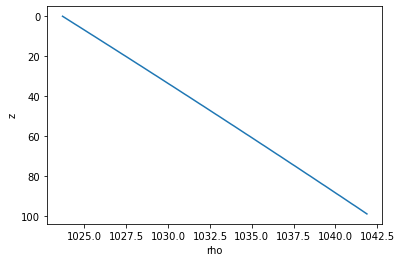

In [20]:
ds.rho.mean(dim={'x','y'}).plot(y="z")
plt.gca().invert_yaxis()

(100, 40, 60)

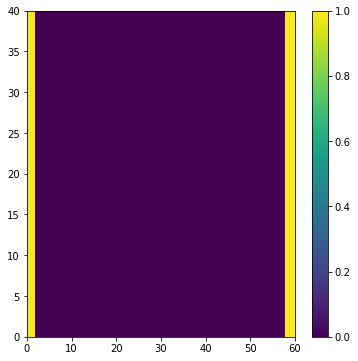

In [56]:
# 3-D mask for RBCS temperature relaxation
# note we implement "sponge layer" with full restoring at E and W boundary row (j=39),
rbcs_mask = np.zeros([nr, ny, nx])
rbcs_mask[:,:,:2] = 1.0
rbcs_mask[:,:,-2:] = 1.0


plt.figure(figsize=(6,6))
cb=plt.pcolormesh(np.arange(0,nx+1,1),np.arange(0,ny+1,1),rbcs_mask[0,:,:])
plt.colorbar(cb)
rbcs_mask.astype('>f4').tofile(f'rbcs_mask_{len(dr)}_25km.bin')
rbcs_mask.shape


# Have an e-folding temperature scale

(100, 40, 60)


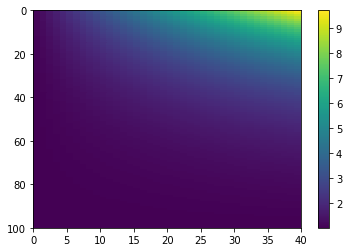

In [5]:
Tmax = 10.
Tmin = 1.
# 3-D Temperature field for initial conditions and RBCS northern wall profile
h = 1000             # e-folding scale for temperature decrease with depth
T_surf = np.zeros([ny, nx]) + np.reshape(
            Tmin + (Tmax-Tmin)/ny * np.linspace(0.5,39.5,ny),[ny,1]) # at (XC,YC) points
zscale = (exp(-z/h) - exp(H/h)) / (1 - exp(H/h))
zscale = np.reshape(zscale, [nr,1,1])
T_3D = np.reshape(T_surf - Tmin, [1,ny,nx]) * zscale + Tmin
print(T_3D.shape)
plt.pcolormesh(T_3D[:,:,10])
plt.colorbar()
#plt.ylim(0,2000)
plt.gca().invert_yaxis()
#plt.xlabel('Y-distance [km]')
#plt.ylabel('Depth [m]')

T_3D.astype('>f4').tofile(f'T_initw_{len(dr)}_25km.bin')

Text(0, 0.5, 'Y-distance [km]')

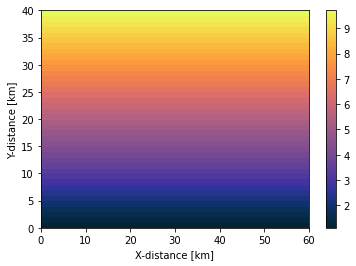

In [6]:
import cmocean.cm as cmo
plt.pcolormesh(T_3D[0,:,:],cmap=cmo.thermal)
plt.colorbar()
plt.xlabel('X-distance [km]')
plt.ylabel('Y-distance [km]')

In [7]:
# create boundary files for obcs with dimension t(=x),z,y
print(T_3D.shape)
Tobcstw=np.transpose(T_3D,(2,0,1))
Tobcstw.shape

Tobcstw.astype('>f4').tofile(f'T_obcstw_{len(dr)}_25km.bin')

(100, 40, 60)


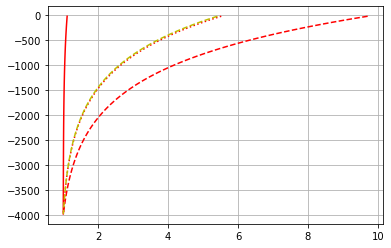

In [9]:

#plt.plot(Tprof100,-1*z)
plt.plot(T_3D[:,0,0],-1*z,color='r')
plt.plot(T_3D[:,20,0],-1*z,color='r',ls=':')
plt.plot(T_3D[:,-1,0],-1*z,color='r',ls='--')
plt.plot(np.mean(T_3D,axis=1)[:,59],-1*z,color='y',ls='--')
plt.grid()

In [10]:
# compute density from T_field
g=9.81
f=gsw.f(-65)
# compute pressure and density
p=np.zeros((nx,ny,nr))+gsw.p_from_z(-1*z,-65)
print(p.shape)
rho=gsw.rho(np.zeros(T_3D.shape)+30,T_3D, p.T)
rho.shape

(60, 40, 100)


(100, 40, 60)

<ipython-input-11-b0457f5c5ae4>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Y,z,rho[:,:,59])


Text(0, 0.5, 'Depth [m]')

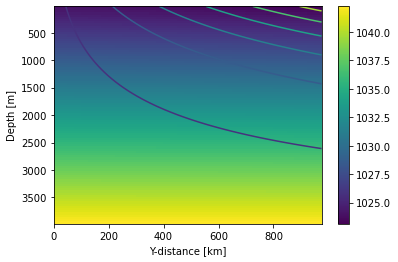

In [11]:
plt.pcolormesh(Y,z,rho[:,:,59])
plt.colorbar()
plt.contour(Y,z[:],T_3D[:,:,59])


plt.gca().invert_yaxis()
plt.xlabel('Y-distance [km]')
plt.ylabel('Depth [m]')

In [12]:
#compute thermal wind

In [13]:
ds = xr.Dataset()
ds['rho'] = (('z', 'y', 'x'), rho)
ds = ds.assign_coords(x=ds.x, y=ds.y, z=ds.z)
ds.x.attrs['axis'] = 'X'
ds.y.attrs['axis'] = 'Y'
ds.z.attrs['axis'] = 'Z'
ds = xgcm.generate_grid_ds(ds, {'X':'x', 'Y':'y', 'Z':'z'})
grid = xgcm.Grid(ds, periodic=False)
ds['dr'] = ('z', dr)

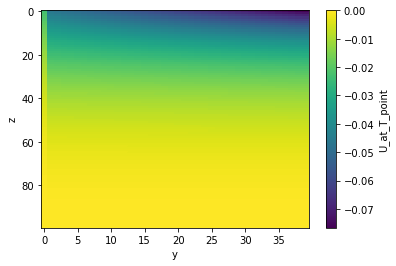

In [14]:
rev = -1*(g/f)*grid.cumsum(
    (
        grid.interp(1/ds.rho, 'Y', boundary='extend') * grid.diff(ds.rho, 'Y', boundary='extend') / (dy*10**3)
    ) * ds.dr,
    'Z',
    boundary='fill',
    fill_value=0
)
velocity = rev.isel(z_left=-1) - rev
ds['U_at_T_point'] = grid.interp(velocity, ['Y', 'Z'], boundary='extend')
ds['U_at_T_point'].mean('x').plot(y='z', yincrease=False)

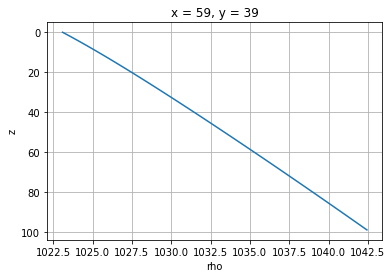

In [15]:
ds.rho.isel(x=59,y=39).plot(y="z")
plt.gca().invert_yaxis()
plt.grid()

In [64]:
U_tw=np.asarray(ds.U_at_T_point.transpose("x", "z", "y"))
print(U_tw.shape)
U_tw.astype('>f4').tofile(f'Uvel_tw_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 

(60, 100, 40)
